In [16]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("oktayrdeki/heart-disease")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Francisco\.cache\kagglehub\datasets\oktayrdeki\heart-disease\versions\1


In [37]:
#df = pd.read_csv("./data/heart_disease.csv")

# Display first few rows
#print(df.head())


In [17]:
# All imports needed
%pip install pandas numpy scikit-learn

import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from enum import Enum

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
def load_data(file_path: str):
    """
    Returns a DataFrame object of the csv file passed in.

    :param file_path: String of the file path to load in

    :return: A DataFrame object of the csv data
    """
    assert(isinstance(file_path, str)), "File path must be a valid path"
    # file_path = "./data/heart_disease.csv"
    df = pd.read_csv(file_path)
    return df

In [19]:
def get_data_info(data_frame):
    """
    View the structure of the data frame

    :param data_frame: The data frame to get the structure of
    """
    assert(isinstance(data_frame, pd.DataFrame)), "The input must be DataFrame object"
    print("Summary of Dataset:")
    data_frame.info()
    print("Get missing count")
    data_frame.isnull().sum() 

In [20]:
def get_num_rows(data_frame: pd.DataFrame):
    """
    Get number of rows of the data frame

    :param data_frame: The data frame to get the number of rows
    """
    assert(isinstance(data_frame, pd.DataFrame)), "The input must be DataFrame object"
    return data_frame.shape[0]

In [21]:
def get_num_cols(data_frame: pd.DataFrame):
    """
    Get number of columns of the data frame

    :param data_frame: The data frame to get the number of columns
    """
    assert(isinstance(data_frame, pd.DataFrame)), "The input must be DataFrame object"
    return data_frame.shape[1]

In [22]:
def classify_non_numerical_columns(data_frame):
    """
    Classification model that predicts the output of non-numerical
    data in the data frame for missing entries.

    :param data_Frame: The data_frame.

    :return: A new data frame with all of the classified columns.
    """
    assert(isinstance(data_frame, pd.DataFrame)), "The input must be DataFrame object"
    non_numeric_cols = data_frame.select_dtypes(exclude=['number']).columns
    for col in non_numeric_cols:
        label_encoder = LabelEncoder()
        data_frame[col] = label_encoder.fit_transform(data_frame[col])
    return data_frame

In [48]:
def drop_random_rows_gender(data_frame: pd.DataFrame):
    """
    Drop random rows from the given pandas DataFrame.
    Used to drop random gender entries (Men and Women)
    to do cleaner data analysis to match number of 
    men and women entries in the dataset.

    :param df: The pandas DataFrame if the number of Men
    does not match the number of Women entries in the DataFrame.
    """
    assert(isinstance(data_frame, pd.DataFrame) and data_frame.shape[0] > 0), "Argument must be a valid non-empty pandas DataFrame"
    assert("Gender" in data_frame.columns), "There must be a Gender column in the pandas DataFrame"
    ser = data_frame["Gender"].value_counts()
    num_men, num_women = ser["Male"], ser["Female"]
    assert(num_men > 0 and num_women > 0), "Number of men and women in the DataFrame should be greater than 0. If not, not a good dataset"
    if num_men > num_women:
        # Drop (num_men - num_women) rows from the DataFrame that contain "Male" column entries
        num_to_drop = num_men - num_women
        indices_to_drop = data_frame[data_frame["Gender"] == "Male"].sample(num_to_drop).index
        data_frame = data_frame.drop(indices_to_drop)
    elif num_women > num_men:
        # Drop (num_women - num_men) rows from the DataFrame that contain "Female" column entries
        num_to_drop = num_women - num_men
        indices_to_drop = data_frame[data_frame["Gender"] == "Female"].sample(num_to_drop).index
        data_frame = data_frame.drop(indices_to_drop)
    return data_frame

In [49]:
class ImputerMethod(Enum):
    KNN = "KNN"
    SIMPLE = "Simple"
    DROP = "Drop"

def clean_data(data_frame: pd.DataFrame, method: ImputerMethod):
    """ 
    Clean the data up from any missing values (if any) by just dropping
    these rows or by using KNN Imputer on numerical columns and
    Simple Imputer on non-numerical columns. Produces a cleaned
    data frame without missing entries. 

    :param data_frame: The data frame to clean up

    :param method: The method of cleaning the data. Can either drop all rows with missing entries,
    or use KNN Imputer on numerical columns and simple Imputer on non-numericla columns.
    Method is of type ImputerMethod enum.

    :return: The cleaned data frame if there are any rows that have missing entries
    """
    assert(isinstance(data_frame, pd.DataFrame)), "The input must be DataFrame object"
    assert(isinstance(method, ImputerMethod)), "The input must be an imputer method either KNN or SIMPLE"

    if data_frame.isnull().any(axis=1).sum():
        if method == ImputerMethod.KNN:
            # KNNImputer only works on numerical data
            # Apply to numerical columns with missing values
            numerical_cols = data_frame.select_dtypes(include=['number']).columns
            knn_imputer = KNNImputer(n_neighbors=5)
            data_frame[numerical_cols] = knn_imputer.fit_transform(data_frame[numerical_cols])

            # Apply SimpleImputer for non-numerical columns
            non_numerical_cols = data_frame.select_dtypes(exclude=['number']).columns
            mode_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            data_frame[non_numerical_cols] = mode_imputer.fit_transform(data_frame[non_numerical_cols])
        elif method == ImputerMethod.DROP:
            data_frame = data_frame.dropna()
    data_frame = drop_random_rows_gender(data_frame)
    return data_frame

In [50]:
def run():
    """
    Main function to run the complete data processing/cleaning.

    :return: df_cleaned_drop, df_cleaned_knn which are the
    cleaned up datasets with their respective methods.
    """
    df = load_data("../data/heart_disease.csv")
    print(f"Num rows before cleaning: {get_num_rows(df)}")
    print(f"Num of cols before cleaning: {get_num_cols(df)}\n")

    df_cleaned_drop = clean_data(df, ImputerMethod.DROP)
    print(f"Num of rows after cleaning with DROP: {get_num_rows(df_cleaned_drop)}")
    print(f"Num of cols after cleaning with DROP: {get_num_cols(df_cleaned_drop)}")
    duplicate_counts = df_cleaned_drop.duplicated().sum()
    print(f"Duplicate rows in cleaned DROP: {duplicate_counts}\n")

    df_cleaned_knn = clean_data(df, ImputerMethod.KNN)
    print(f"Num of rows after cleaning with KNN: {get_num_rows(df_cleaned_knn)}")
    print(f"Num of cols after cleaning with KNN: {get_num_cols(df_cleaned_knn)}")
    duplicate_counts = df_cleaned_knn.duplicated().sum()
    print(f"Duplicate rows in cleaned KNN: {duplicate_counts}\n")
    
    return df_cleaned_drop, df_cleaned_knn

In [51]:
df_cleaned_drop, df_cleaned_knn = run()

cleaned_drop_series = df_cleaned_drop["Gender"].value_counts()
print(f"{cleaned_drop_series}\n")
num_men_drop, num_women_drop = cleaned_drop_series
print(f"Number of men in clean with DROP: {num_men_drop}")
print(f"Number of women in clean with DROP: {num_women_drop}\n")

cleaned_knn_series = df_cleaned_knn["Gender"].value_counts()
print(f"{cleaned_knn_series}\n")
num_men_knn, num_women_knn = cleaned_knn_series
print(f"Number of men in clean with KNN: {num_men_knn}")
print(f"Number of women in clean with KNN: {num_women_knn}")


Num rows before cleaning: 10000
Num of cols before cleaning: 21

Num of rows after cleaning with DROP: 7006
Num of cols after cleaning with DROP: 21
Duplicate rows in cleaned DROP: 0

Num of rows after cleaning with KNN: 9956
Num of cols after cleaning with KNN: 21
Duplicate rows in cleaned KNN: 0

Gender
Female    3503
Male      3503
Name: count, dtype: int64

Number of men in clean with DROP: 3503
Number of women in clean with DROP: 3503

Gender
Male      4978
Female    4978
Name: count, dtype: int64

Number of men in clean with KNN: 4978
Number of women in clean with KNN: 4978


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
def Age_with_X(X):
    '''
    explore factor X with Heart disease rate among different age
    '''
    # Mapping Heart Disease Status from categorical ('Yes'/'No') to binary (1/0)
    if df_cleaned_drop['Heart Disease Status'].dtype == 'O': 
        mapping = {'Yes': 1, 'No': 0}
        df_cleaned_drop['Heart Disease Status'] = df_cleaned_drop['Heart Disease Status'].map(mapping)

    # Create age groups 
    bins = [0, 30, 40, 50, 60, 70, 80, 100]
    labels = ['<30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+']
    df_cleaned_drop['AgeGroup'] = pd.cut(df_cleaned_drop['Age'], bins=bins, labels=labels, right=False)

    # Group by AgeGroup and Smoking to calculate the average (proportion) of heart disease.
    # Since Heart Disease Status is 0/1, the mean gives the proportion of cases.
    result = df_cleaned_drop.groupby(['AgeGroup', X])['Heart Disease Status'].mean().reset_index()
    # print("Heart Disease Proportion by Age Group and %s Status:" % X)
    # print(result)

    # Visualize the proportions with a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=result, x='AgeGroup', y='Heart Disease Status', hue= X)
    plt.ylabel('Proportion with Heart Disease')
    plt.title('Heart Disease Proportion by %s Status and Age Group' % X)

    # Save the figure before showing it
    filename = f'heart_disease_proportion_by_{X}.png'  # Saves dynamically based on X
    plt.savefig(filename, dpi=300, bbox_inches='tight')  # Save at high quality

    # plt.show()

C:\Users\Francisco\AppData\Local\Temp\ipykernel_17528\1685466182.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df_cleaned_drop.groupby(['AgeGroup', X])['Heart Disease Status'].mean().reset_index()
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17528\1685466182.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df_cleaned_drop.groupby(['AgeGroup', X])['Heart Disease Status'].mean().reset_index()
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17528\1685466182.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. 

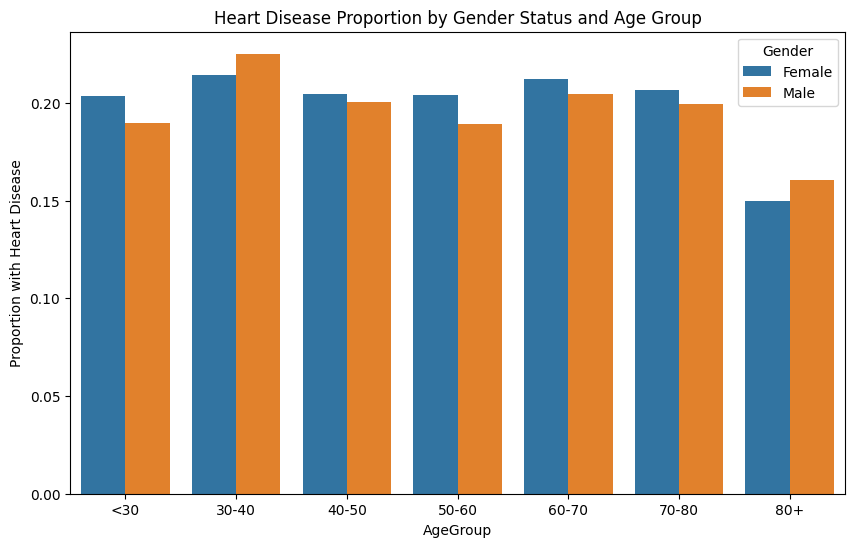

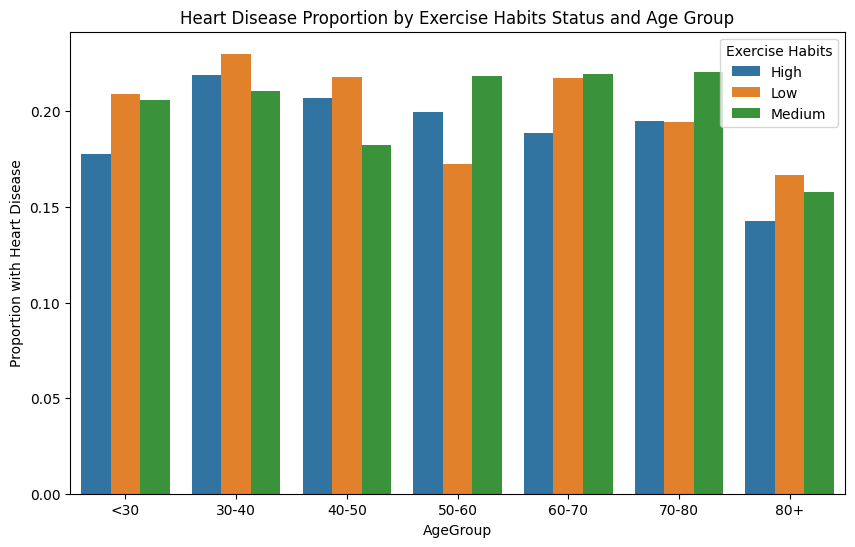

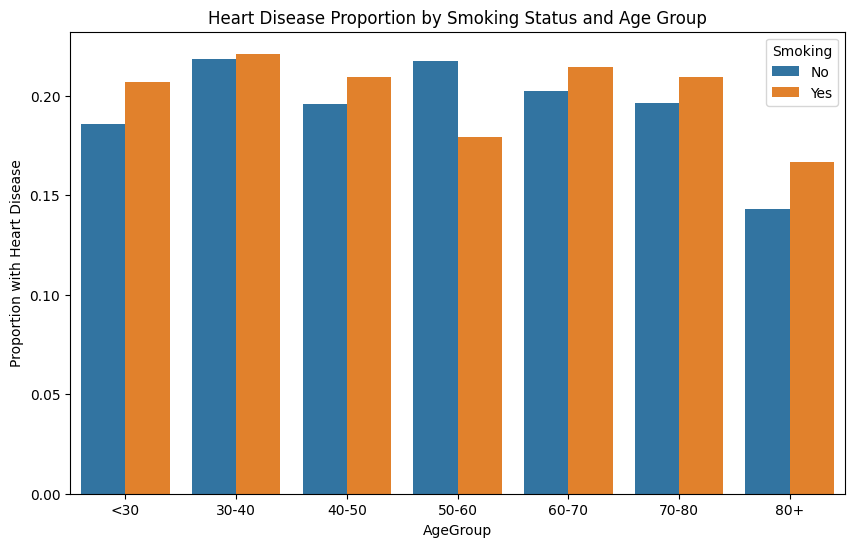

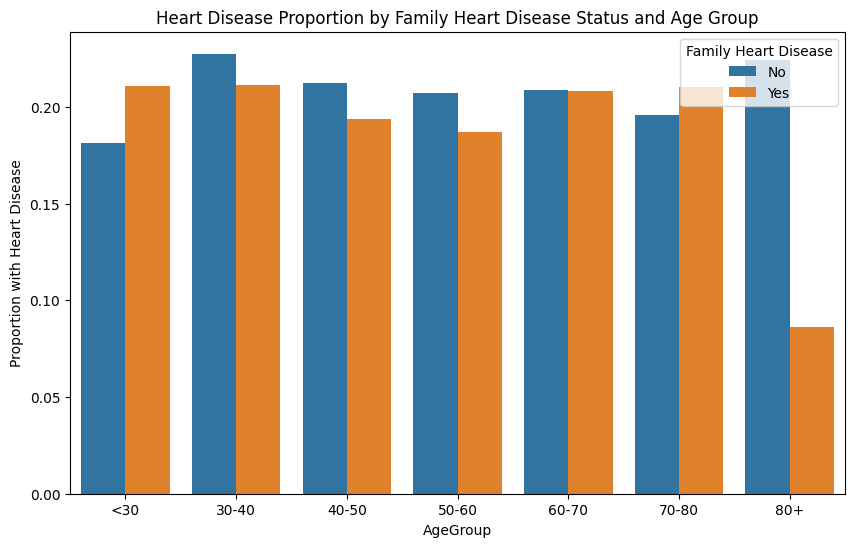

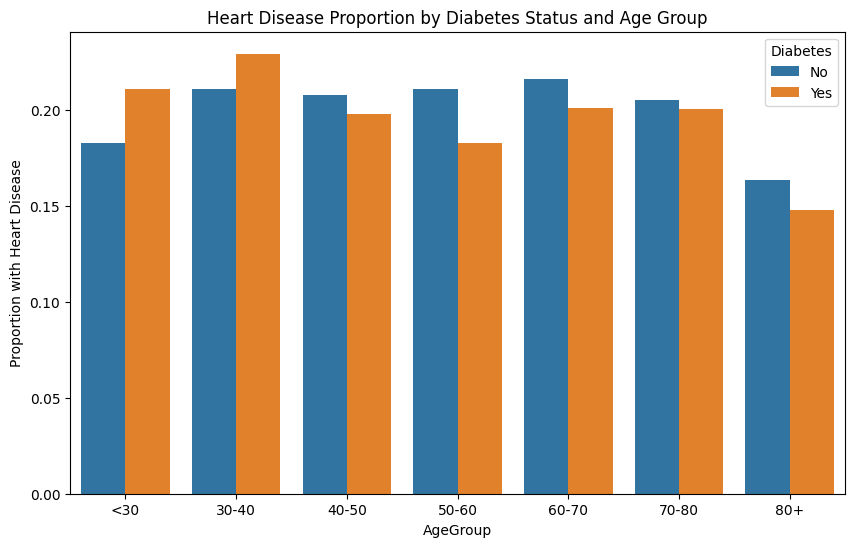

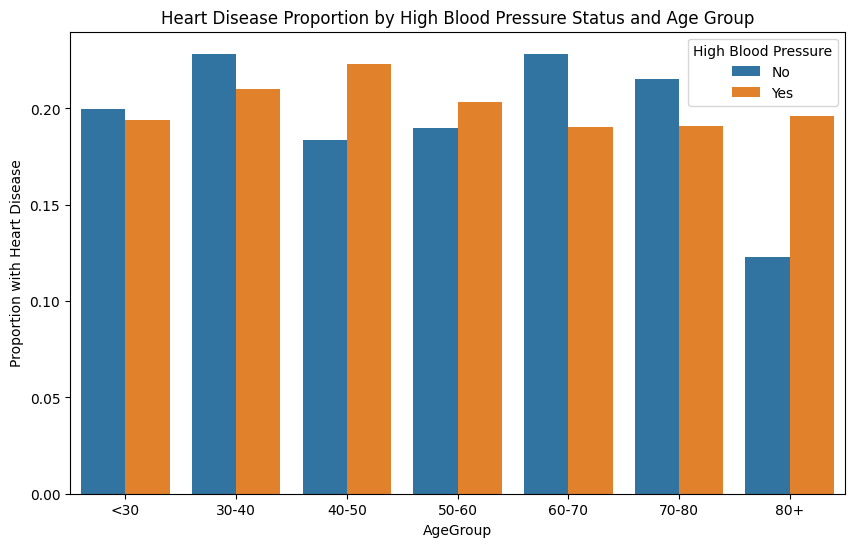

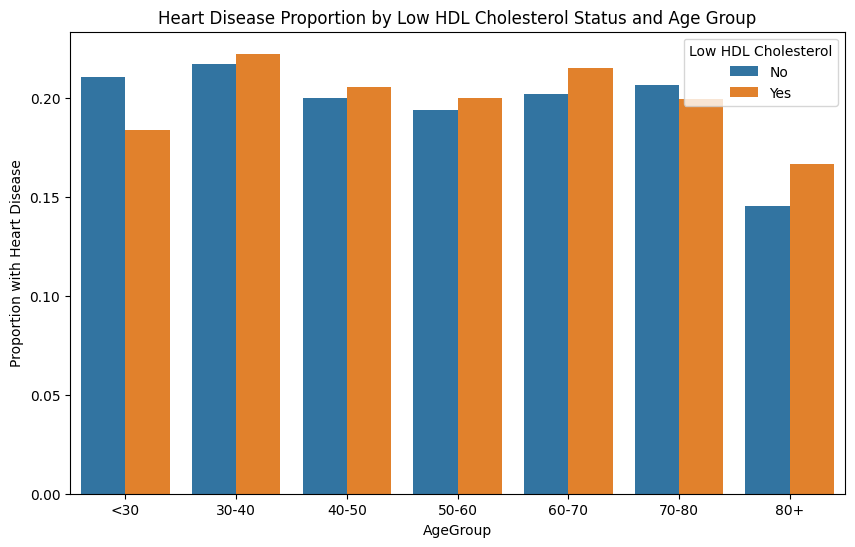

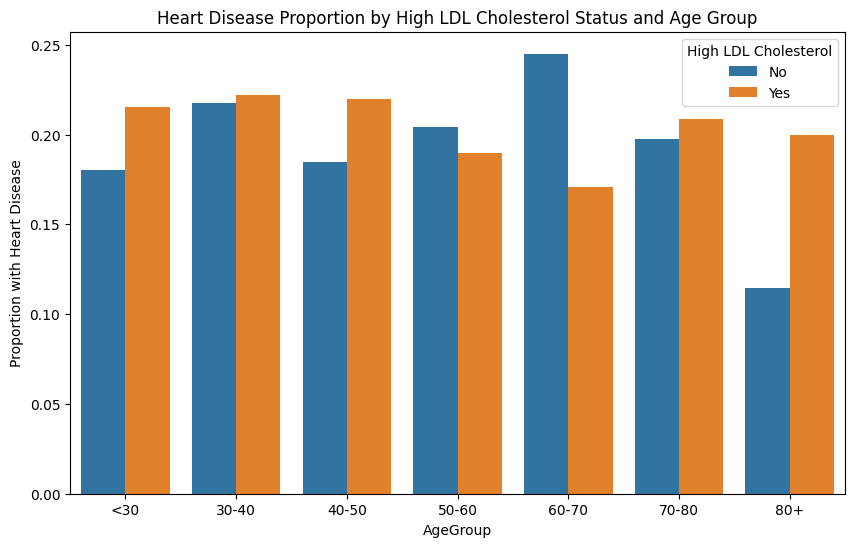

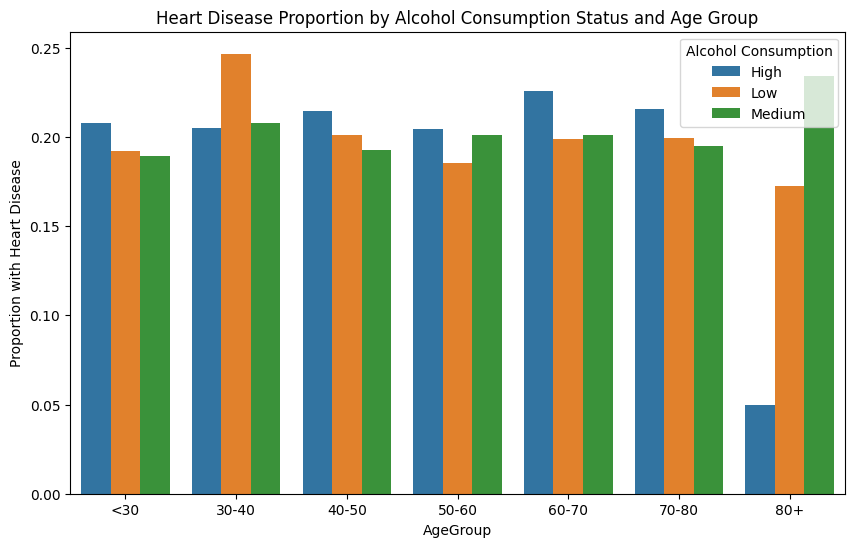

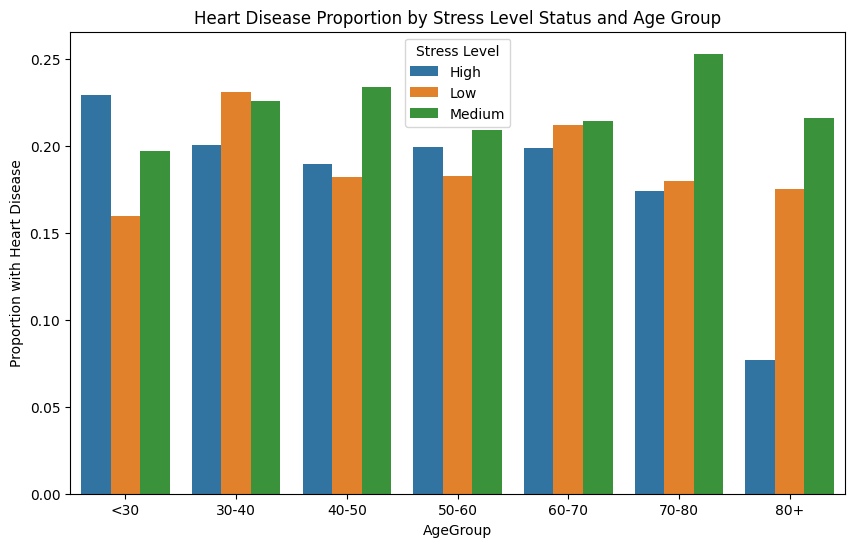

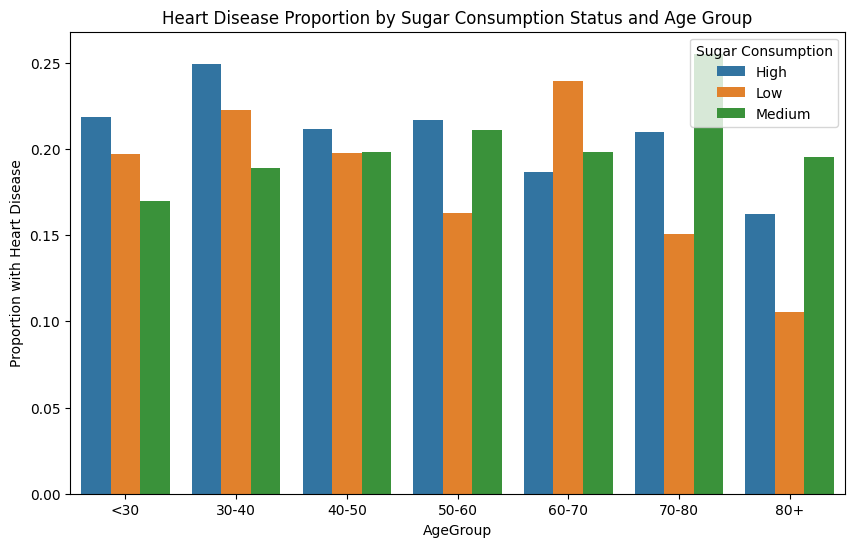

In [53]:
categorical_columns = df_cleaned_drop.select_dtypes(include=['object', 'category']).columns.tolist()

for cate in categorical_columns[:len(categorical_columns)-1]:
    Age_with_X(cate)